In [289]:
# 收集基本数据
import os
import pandas
from PIL import Image
import torch.utils.data

class MedicPicDataset(torch.utils.data.Dataset):
    def __init__(self, root,transforms=None):
        self.root = root

        # load all image files, sorting them to ensure that they are aligned

        self.imgs = list(sorted(os.listdir(os.path.join(root,"MedImgs"))))

        self.transforms = transforms

    def __getitem__(self, item):

        # read imgs
        item=item+1  # 从1开始
        img_name = "1-"+str(item) +".tif"
        img_path = os.path.join(self.root,"MedImgs",img_name)
        item_data = Image.open(img_path)


        # transform data
        if self.transforms:
            item_data = self.transforms(item_data)


        # read label of the dataset
        label_file_path = os.path.join(self.root,"label.xlsx")
        label_data = pandas.read_excel(label_file_path)
        item_label = label_data.iloc[item-1,2]
        return item_data, item_label


    def __len__(self):
        return len(self.imgs)


In [290]:
# 构造平衡的训练集和测试集
# 统计100样本下，label 1 的数量为38， label 0 的数量为62，基本平衡，因此在这里只简单进行shuffle

# 图像基本处理 —— 标准化
from torchvision import transforms as T
transforms = T.Compose([
    T.Resize(32),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

])

TRAIN_RATE = 0.7
VALIDATE_RATE = 0
dataset = MedicPicDataset(root="./",transforms=transforms)

dataset_len = dataset.__len__()
temp = list(range(dataset_len))
train_size = int(dataset_len * TRAIN_RATE)
validate_size = int(dataset_len * VALIDATE_RATE)
test_size = dataset_len - train_size - validate_size


from torch.utils.data import Dataset, DataLoader
train_dataset, validate_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,validate_size,test_size])


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False,num_workers=0)
validate_loader = DataLoader(validate_dataset, batch_size=1, shuffle=False,num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,num_workers=0)


In [291]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
def imshow(img):
    img = img /2 + 0.5   # why ?
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# imshow(torchvision.utils.make_grid(iter(train_loader).__next__()[0]))

In [292]:
# 搭建CNN网络

import torch
from torch import nn
import torch.nn.functional as F


def num_flat_feature(x):
    size = x.size()[1:]
    num_feature = 1
    for s in size:
        num_feature *= s
    return num_feature


class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        ##
        self.conv1 = nn.Conv2d(3, 6, 5)  # three channels, six conventional kernel, the kernel size is 5x5
        # self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)


        ##
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))

        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))

        # 计算？
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        # x = x.view(-1, num_flat_feature(x))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self,x):
        size = x.size()[1:]
        num_feature = 1
        for s in size:
            num_feature *= s
        return num_feature

net= Net()
print(net)
params = list(net.parameters())
print(len(params))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10


In [293]:
# 损失函数和优化器
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [294]:
# training

EOPCH = 100

for epoch in range(EOPCH):
    running_loss = 0.0

    # get the inputs
    for i, data in enumerate(train_loader,0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

In [295]:
# dataiter = iter(test_dataset)
for i in range(99):
    images, labels = dataset.__getitem__(i)
    outputs=net(images[None,...])
    _, predicted = torch.max(outputs,1)



In [296]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs.data ,1)
        total = total + 1
        if predicted == labels:
            correct = correct + 1

print(correct/total)

0.9666666666666667


In [297]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import InputXGradient
from captum.attr._core.guided_backprop_deconvnet import GuidedBackprop
from captum.attr._core.guided_grad_cam import GuidedGradCam
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import DeepLiftShap
from captum.attr import visualization as viz

In [303]:
ind = 0
device = torch.device("cpu")
dataiter = iter(test_loader)
images, labels = dataiter.__next__()
images = images.to(device)

# 尝试读取多个

# original_image = np.transpose(images[ind].cpu().detach().numpy() , (1, 2, 0))
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
# original_image = np.repeat(original_image,3,axis=-1)

# fig,axis = viz.visualize_image_attr(None, original_image,
#                           method="original_image", title="Original Image")
# fig.savefig('figures/8_orig.png')
# plt.close()



In [299]:
# A generic function that will be used for calling `attribute` on attribution algorithm defined in input.



def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=predicted[ind],
                                              **kwargs
                                             )

    return tensor_attributions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


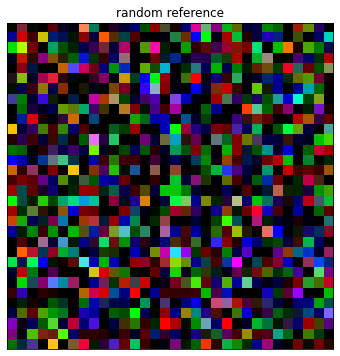

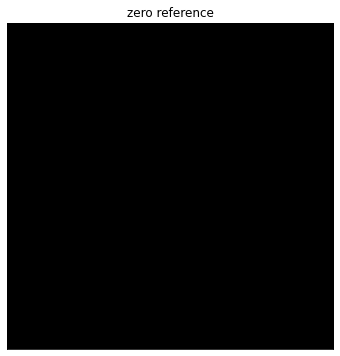

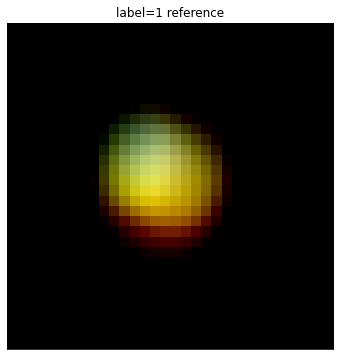

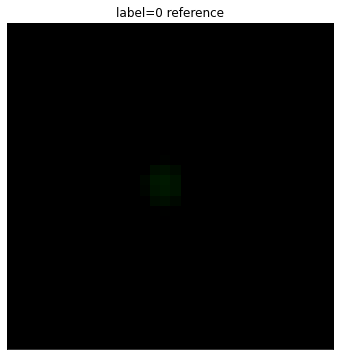

In [312]:
# 获取 distribution 的 dataloader


def get_distribution_dataindex(root, label):
        label_file_path = os.path.join(root,"label.xlsx")
        label_data = pandas.read_excel(label_file_path)
        return label_data[label_data["output"]==label].index

def generate_distribution_data(index,length,reference_np,dataset):
    index = index.to_list()
    import random
    random.shuffle(index)
    for sample in range(length):
        reference_np[sample],label = dataset.__getitem__(index[sample])
    return torch.from_numpy(reference_np)




def plot_reference_data(background,name):
    background = background.numpy()
    background = np.mean(background,axis=0)
    background = np.transpose(background,(1, 2, 0))
    # background = np.repeat(background,3,axis=-1)/255
    fig,axis = viz.visualize_image_attr(None, background,
                          method="original_image", title=name)
    fig.savefig("figures/"+name)
    return background


sample_number = 5

random_label_reference = torch.randn((sample_number,3,32,32))
random_background = plot_reference_data(random_label_reference,"random reference")

zero_label_reference = torch.zeros((sample_number,3,32,32))
zero_background = plot_reference_data(zero_label_reference,"zero reference")


label_reference_np = np.empty((sample_number,3,32,32), dtype = float, order = 'C')
label_index =  get_distribution_dataindex("./",1)
label1_reference_np = generate_distribution_data(label_index,sample_number,label_reference_np,dataset)

label1_background = plot_reference_data(torch.from_numpy(label_reference_np),"label=1 reference")


label_reference_np = np.empty((sample_number,3,32,32), dtype = float, order = 'C')
label_index =  get_distribution_dataindex("./",0)
label0_reference_np = generate_distribution_data(label_index,sample_number,label_reference_np,dataset)
label0_background = plot_reference_data(torch.from_numpy(label_reference_np),"label=0 reference")


In [301]:
# Define a few baseline methods
# Computes gradients with respect to class `ind` and transposes them for visualization purposes.
order = 0

input= images[ind].unsqueeze(0)
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[order].item(), abs=False)
grads = np.transpose(grads.squeeze(axis=0).cpu().detach().numpy(), (1, 2, 0))

# Guided Propogate
gbp = GuidedBackprop(net)
attr_gbp = attribute_image_features(gbp, input)
attr_gbp = np.transpose(attr_gbp.squeeze(axis=0).cpu().detach().numpy(), (1, 2, 0))

input = input.cpu()
net = net.to('cpu')

# DeepLift
# the reference of deeplift?
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

# DeepLiftShap

# reference distribution:
## zero  reference
ds = DeepLiftShap(net)
attr_ds = attribute_image_features(ds, input, baselines=zero_label_reference.view(-1,3,32,32).float())
attr_ds = np.transpose(attr_ds.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

## random reference
attr_ds_r = attribute_image_features(ds, input, baselines=random_label_reference.view(-1,3,32,32).float())
attr_ds_r = np.transpose(attr_ds_r.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


## label=1 reference
attr_ds_1 = attribute_image_features(ds, input, baselines=label1_reference_np.view(-1,3,32,32).float())
attr_ds_1 = np.transpose(attr_ds_1.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

## label=0 reference

attr_ds_0 = attribute_image_features(ds, input, baselines=label0_reference_np.view(-1,3,32,32).float())
attr_ds_0 = np.transpose(attr_ds_0.squeeze(0).cpu().detach().numpy(), (1, 2, 0))



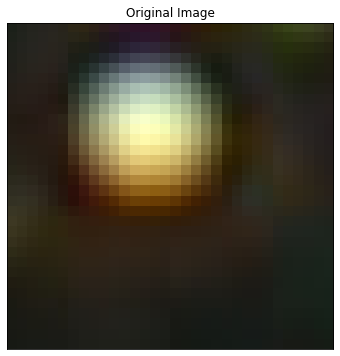

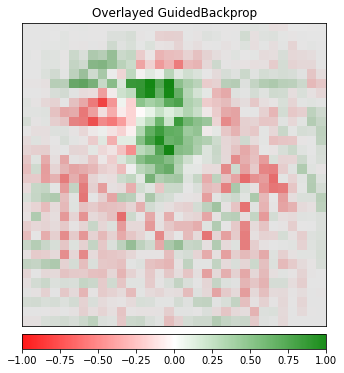

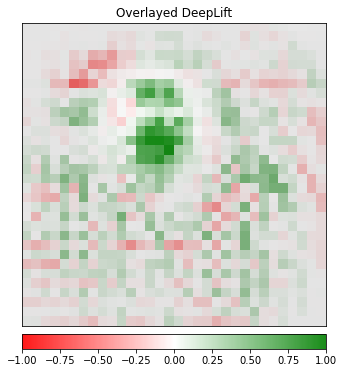

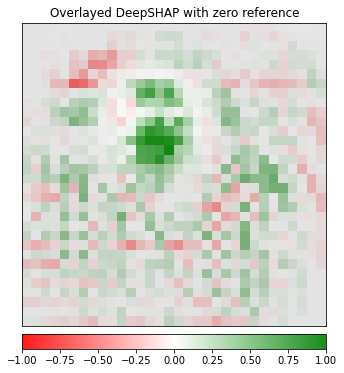

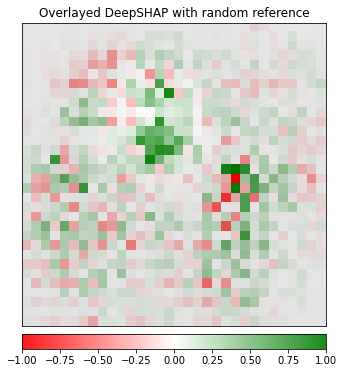

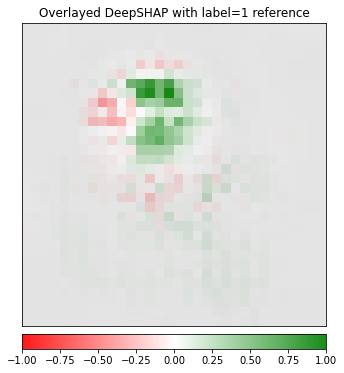

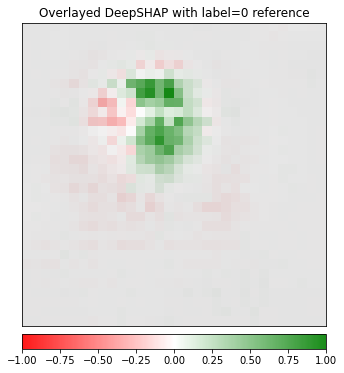

In [309]:
# original images
fig,axis = viz.visualize_image_attr(None, original_image,
                          method="original_image", title="Original Image")
fig.savefig('figures/original_image.png')
plt.close()


# guidedbackprop
fig,axis = viz.visualize_image_attr(attr_gbp, original_image, method="blended_heat_map",sign="all",
                              show_colorbar=True, title="Overlayed GuidedBackprop",alpha_overlay=0.9)
fig.savefig('figures/guidedbackprop.png')
plt.close()


# deeplift
fig,axis = viz.visualize_image_attr(attr_dl/attr_dl.max(), original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                              title="Overlayed DeepLift",alpha_overlay=0.9)
fig.savefig('figures/deeplift.png')
plt.close()

# deepshap with zero reference
fig,axis = viz.visualize_image_attr(attr_ds, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepSHAP with zero reference",alpha_overlay=0.9)
fig.savefig('figures/deepshap with zero ref.png')
plt.close()

# deepshap with random reference
fig,axis = viz.visualize_image_attr(attr_ds_r, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepSHAP with random reference",alpha_overlay=0.9)
fig.savefig('figures/deepshap with random ref.png')
plt.close()

# deepshap with label=1 reference
fig,axis = viz.visualize_image_attr(attr_ds_1, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepSHAP with label=1 reference",alpha_overlay=0.9)
fig.savefig('figures/deepshap with label1 ref.png')
plt.close()

# deepshap with label=0 reference
fig,axis = viz.visualize_image_attr(attr_ds_0, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepSHAP with label=0 reference",alpha_overlay=0.9)
fig.savefig('figures/deepshap with label0 ref')
plt.close()

